In [1]:
import pandas as pd 
import numpy as np
import copy 
import random
from matplotlib import pyplot as plt 
from glob import glob
import re
import nltk
from numpy.linalg import norm
from scipy.spatial.distance import pdist
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
stop = stopwords.words('english')
from nltk import pos_tag
import seaborn as sns; sns.set()

/Users/Christine/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
rawdata = "/Users/Christine/Library/Mobile Documents/com~apple~CloudDocs/Patent/rawdata"
workdata = "/Users/Christine/Library/Mobile Documents/com~apple~CloudDocs/Patent/workdata"

In [3]:
merge_data =  pd.read_csv(f'{workdata}/merge3.csv')
merge_data.columns

Index(['zlid', 'firm_ID', 'province', 'city', 'CIC4dig', 'regi_type',
       'fixed_assets', 'paid_capital', 'state_cap', 'collective_cap',
       'corporate_cap', 'individual_cap', 'HMT_cap', 'foreign_cap',
       'APPLN_ID_SIPO', 'year', 'APPLN_ID', 'APPLN_FILING_DATE',
       'appln_nr_original', 'DOCDB_FAMILY_ID', 'DOCDB_FAMILY_SIZE',
       'APPLN_ABSTRACT', 'Priority_date', 'Publication_date', 'kind2',
       'PubNum_google', 'Citation_abstract', 'Patent Office'],
      dtype='object')

In [20]:
## pooling patent and citing all together; 
## in the next step to cal dist, we will define PAIRS, that is the structre: ['APPLN_ID_SIPO','PubNum_google']

patent_data = merge_data[['APPLN_ID_SIPO', 'APPLN_ABSTRACT']]
patent_data.drop_duplicates(subset=['APPLN_ID_SIPO'], 
                                keep='first', 
                                inplace=True, 
                                ignore_index=True)
patent_data.rename(columns={'APPLN_ID_SIPO':'Patent_ID', 'APPLN_ABSTRACT':'Patent_abstract'}, inplace=True)
patent_data

/var/folders/n5/z1zm8jvn39b3kjy2k56p_8240000gn/T/ipykernel_42770/2197333536.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patent_data.drop_duplicates(subset=['APPLN_ID_SIPO'],
/var/folders/n5/z1zm8jvn39b3kjy2k56p_8240000gn/T/ipykernel_42770/2197333536.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patent_data.rename(columns={'APPLN_ID_SIPO':'Patent_ID', 'APPLN_ABSTRACT':'Patent_abstract'}, inplace=True)


,Patent_ID,Patent_abstract
0,CN98118142.2,A Chinese patent medicine in the form of capsu...
1,CN200710126165.3,The invention discloses a method and apparatus...
2,CN200610060717.0,The method comprises: receiving an audio signa...
3,CN00103340.9,A device for eliminating the mini ice crystal ...
4,CN200710075612.7,The invention provides a method of producing s...
...,...,...
54517,CN200710158939.0,The invention relates to a resin-reinforcing h...
54518,CN200710019951.3,The invention discloses a making method of ter...
54519,CN200710019952.8,The invention discloses a making method of eur...
54520,CN200710019946.2,The invention discloses a making method of lan...


In [6]:
## drop duplicates version of citing abstract: 
citing_data = merge_data[['PubNum_google', 'Citation_abstract']]
citing_data.drop_duplicates(subset=['PubNum_google'], 
                                keep='first', 
                                inplace=True, 
                                ignore_index=True)

citing_data.rename(columns={'PubNum_google':'Patent_ID', 'Citation_abstract':'Patent_abstract'}, inplace=True)
citing_data = citing_data[citing_data["Patent_abstract"]!="Not Found"]
citing_data

/var/folders/n5/z1zm8jvn39b3kjy2k56p_8240000gn/T/ipykernel_42770/3539906453.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  citing_data.drop_duplicates(subset=['PubNum_google'],
/var/folders/n5/z1zm8jvn39b3kjy2k56p_8240000gn/T/ipykernel_42770/3539906453.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  citing_data.rename(columns={'PubNum_google':'Patent_ID', 'Citation_abstract':'Patent_abstract'}, inplace=True)


,Patent_ID,Patent_abstract
1,US5644677,A signal processing system (50) performs real-...
3,US5572591,"According the present invention, a sound field..."
4,JPH09322078,PROBLEM TO BE SOLVED: To attain phone contact ...
5,US5396560,This invention discloses a hearing aid includi...
6,US5146504,An automatic gain control circuit uses a speec...
...,...,...
242832,CN1017887B,The present invention relates to a technologic...
242833,CN2676102Y,The utility model relates to a highly oil/gas ...
242835,CN201062869Y,An energy saving fuel hot air furnace comprise...
242836,US4955359A,A forced-air furnace for burning gas or fuel o...


In [25]:
## concat remerge:  
re_scrawl = pd.read_csv(f'{rawdata}/patent-crawler/patents_data_rescrap.csv', encoding='latin-1')
re_scrawl = re_scrawl[['ID', 'WID', 'Abstract', 'Patent Office']]

re_scrawl.drop_duplicates(subset=['ID'], 
                                keep='first', 
                                inplace=True, 
                                ignore_index=True)
replacement = {
    "Abstract\n\n": '',
    "\n": '',
    "<P>": ''
}
re_scrawl['Abstract'] = re_scrawl['Abstract'].replace(replacement, regex=True)

re_scrawl = re_scrawl[re_scrawl["Abstract"]!="Not Found"]
re_scrawl = re_scrawl[['ID', 'Abstract']]
re_scrawl.rename(columns={'ID':'Patent_ID', 'Abstract':'Patent_abstract'}, inplace=True)

re_scrawl

,Patent_ID,Patent_abstract
0,DE10021977A,The RF security tag has spiral coil (4) made o...
2,US7183917B,A re-usable identification tag that includes a...
4,US20030235027A,A method of making an interactive information ...
6,US20040050724A,The invention concerns a carrier of informatio...
7,EP1083519A,A container 10 comprises a reflective contents...
...,...,...
38625,JPH0217849,PURPOSE: To facilitate stopping rotation of a ...
38796,WO2005017670A,"An embodiment of the invention, for controllin..."
38875,DE202005008280U,A radial fan (20) has an impeller (22) enclose...
38909,KR100211453B,AbstractTranslated from Korean The remote cont...


In [26]:
citing_data2 = pd.concat([citing_data, re_scrawl])

In [27]:
##Pooling together: 
pooling_patent_data = pd.concat([patent_data, citing_data2])
pooling_patent_data.drop_duplicates(subset=['Patent_ID'], 
                                keep='first', 
                                inplace=True, 
                                ignore_index=True)

indexNotfound = pooling_patent_data[(pooling_patent_data['Patent_abstract'] == 'Not Found')].index
pooling_patent_data.drop(indexNotfound , inplace=True)
pooling_patent_data.to_csv(f'{workdata}/pooling_patent_data.csv', index= False) 

In [5]:
pooling_patent_data = pd.read_csv(f'{workdata}/pooling_patent_data.csv')
pooling_patent_data

,Patent_ID,Patent_abstract
0,CN98118142.2,A Chinese patent medicine in the form of capsu...
1,CN200710126165.3,The invention discloses a method and apparatus...
2,CN200610060717.0,The method comprises: receiving an audio signa...
3,CN00103340.9,A device for eliminating the mini ice crystal ...
4,CN200710075612.7,The invention provides a method of producing s...
...,...,...
263667,JPH0217849,PURPOSE: To facilitate stopping rotation of a ...
263668,WO2005017670A,"An embodiment of the invention, for controllin..."
263669,DE202005008280U,A radial fan (20) has an impeller (22) enclose...
263670,KR100211453B,AbstractTranslated from Korean The remote cont...


<AxesSubplot:xlabel='Patent_abstract', ylabel='Count'>

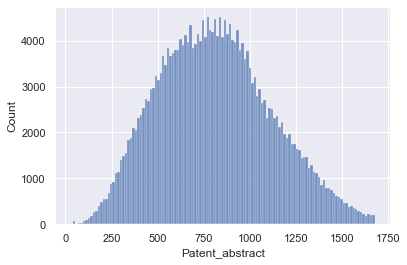

In [29]:
###Distribution of original avstract length:
###Outliers are defined as data points that are more than 1.5 times the IQR away from the upper or lower quartile.
import seaborn as sns
Q1 = pooling_patent_data['Patent_abstract'].str.len().quantile(0.25)
Q3 = pooling_patent_data['Patent_abstract'].str.len().quantile(0.75)
IQR = Q3 - Q1

# Calculate the upper and lower bounds
lower_bound = Q1 - 1.5*IQR
upper_bound = Q3 + 1.5*IQR

# Filter out the outliers
filtered_data = pooling_patent_data.loc[pooling_patent_data['Patent_abstract'].str.len().between(lower_bound, upper_bound)]

# Plot the histogram of the filtered data
sns.histplot(filtered_data['Patent_abstract'].str.len())